In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle
from numpy.lib.stride_tricks import as_strided

In [2]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir="../../original_images/SD"
img_lbls=""
base_model = 'SD/sd_01_.ckpt'
model_20000 = 'SD/sd_20000.ckpt'
model_30000 = 'SD/sd_30000.ckpt'
model_40000 = 'SD/sd_40000.ckpt'
model_50000 = 'SD/sd_50000.ckpt'
model2_50000 = 'SD/sd2_50000.ckpt' #this model takes a 10x10 predicted mask from model:1 and predicts an image which combines all the patches.

connected_model = 'SD/sd_conected.ckpt'

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# filter_size1 = 16          # Convolution filters are 4 x 4 pixels.
# num_filters1 = 64         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 8          # Convolution filters are 2 x 2 pixels.
num_filters2 = 64         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 8          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 4          # Convolution filters are 2 x 2 pixels.
num_filters4 = 32         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 2000             # Number of neurons in fully-connected layer.

# We know that images are 60 pixels in each dimension.
# img_size = 8 * 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 10 * 10

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 1

# Tuple with height and width of images used to reshape arrays.
img_shape = (10, 10, num_channels)

# Number of classes, one class for same or different image
num_classes = 4*2
patch_size = (2, 2, 3)
npatches = 2

In [3]:
def load_data(img_dir):
        list_of_orig_imgs = []
        list_of_pred_imgs = []
        list_of_labels = []
        list_same_diff = []
        list_img_keys = []
        for img in os.listdir(img_dir):
            
            img_path = os.path.join(img_dir, img)
            list_same_diff.append(int(os.listdir(img_path)[0]))
            list_img_keys.append(img)
            img_path = img_path + "/" + os.listdir(img_path)[0]
            for img_label in os.listdir(img_path):
                img_data = os.path.join(img_path, img_label)
                if img_label == "img":
#                     print(img_data + "/img.png")
                    list_of_orig_imgs.append(img_data + "/img.png")
                    list_of_pred_imgs.append(img_data + "/predicted_mask.png")
                else:
                    list_of_labels.append([os.path.join(img_data, label) for label in os.listdir(img_data)])

        data_imgs = np.array([list_of_orig_imgs, list_of_pred_imgs])
        data_labels = np.array(list_of_labels)
        data_same_diff = np.array(list_same_diff)
        data_img_keys = np.array(list_img_keys)

        return data_imgs, data_labels, data_same_diff, data_img_keys

    
def get_batch_images(data_orig, data_pred, label, same_diff, img_keys, rshp, grey_scale):
        list_of_orig_imgs = []
        list_of_pred_imgs = []
        list_of_labels = []
        list_of_same_diff = []
        list_of_img_keys = []
        for img_orig, img_pred, lbl, img_type, img_key in zip(data_orig, data_pred, label, same_diff, img_keys):
            if (grey_scale):
                orig_img = cv2.imread(img_orig)
                predicted_msk = cv2.imread(img_pred, cv2.IMREAD_GRAYSCALE)
            else:
                orig_img = cv2.imread(img[0])
                
            orig_lbl = cv2.imread(lbl)
            if orig_img is None or orig_lbl is None:
                    print ("Unable to read image{} or {}".format(img[0], lbl))
                    continue
            
            if (grey_scale):
                orig_lbl = rgb2grey(orig_lbl)

            flattened_orig_img = orig_img.flatten()
            flattened_pred_img = predicted_msk.flatten()
            flattened_lbl = orig_lbl.flatten()
            
            if grey_scale:
                flattened_lbl = np.reshape(flattened_lbl, [4, 2])
#                 print(flattened_lbl)
#                 flattened_lbl = normalize(flattened_lbl)
#                 print(flattened_lbl)
            
            list_of_orig_imgs.append(np.asarray(flattened_orig_img, dtype=np.float32))
            list_of_pred_imgs.append(np.asarray(flattened_pred_img, dtype=np.float32))
        
            list_of_labels.append(np.asarray(flattened_lbl, dtype=np.float32))
            list_of_same_diff.append(img_type)
            list_of_img_keys.append(img_key)

        data_labels = np.array(list_of_labels)
#         print(data_labels.shape)
#         print(rshp)
#         reshaped_labels = np.reshape(data_labels, rshp)
#         data_labels = np.squeeze(reshaped_labels[:, :, :1])
        data_imgs = np.array([list_of_orig_imgs, list_of_pred_imgs])
        data_img_type = np.array(list_of_same_diff)
        data_img_keys = np.array(list_of_img_keys)
        
        return data_imgs, data_labels, data_img_type, data_img_keys

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data[0]))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_orig = data[0, :]
    data_pred = data[1, :]
    data_orig_shuffle = [data[0, i] for i in idx]
    data_pred_shuffle = [data[1, i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_orig_shuffle), np.asarray(data_pred_shuffle), np.asarray(labels_shuffle)

def rgb2grey(rgb):
    return(np.dot(rgb[...,:3], [0.299, 0.587, 0.114]))

In [4]:
def new_weights(shape, layer_name):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=layer_name+'_W')

def new_bias(length, layer_name):
    return tf.Variable(tf.constant(0.05, shape=[length]), name=layer_name+'_b')

def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   name_scope,
                   layer_name='',
                   use_pooling=True):

    with tf.name_scope(name_scope):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = new_weights(shape, layer_name)
        biases = new_bias(num_filters, layer_name)

        layer = tf.add(tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME'), biases, name=layer_name)

        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 3, 3, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME', name=layer_name+'_max')
            
        layer = tf.nn.relu(layer, name=layer_name+'_activation')

    return layer, weights

def flatten_layer(layer, flag=False):
    layer_shape = layer.get_shape()
    if flag is True:
        num_features = layer_shape.num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    else:
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):
        weights = new_weights([num_inputs, num_outputs], layer_name)
        biases = new_bias(num_outputs, layer_name)

        layer = tf.add(tf.matmul(input, weights),biases,name=layer_name)
    #     layer = tf.matmul(input, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer, layer_name+'_activation')
    
    return layer


def normalise_tensor(tensor):
    return tf.div(
   tf.subtract(
      tensor, 
      tf.reduce_min(tensor)
   ), 
   tf.subtract(
      tf.reduce_max(tensor), 
      tf.reduce_min(tensor)
   )
)

In [5]:
x_o = tf.placeholder(tf.float32, shape=[None, img_size_flat*3], name='x_orig')
x_p = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x_pred')

x_orig_image = tf.reshape(x_o, [-1, 10, 10, 3])
x_pred_image = tf.reshape(x_p, [-1, 10, 10, num_channels])

dims = tf.constant([2,2])
k = tf.constant(npatches)
y_true = tf.placeholder(tf.float32, shape=[None, 4, 2], name='y_true')
# y_true_cls = tf.argmax(y_true, axis=1)
y_true_cls = tf.placeholder(tf.float32, shape=[None, 4, 2], name='y_true_cls')
# x_image.shape, y_true

# input = tf.placeholder(tf.float32, [None, None])

In [61]:
def new_custom_layer(input,
                     orig_img,
                     dims_, 
                     k_,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):

        resh_inp = tf.reshape(input, [-1, 10, 10])
        input_shape = tf.shape(resh_inp)
        print(resh_inp.get_shape())
        rows, cols = input_shape[1], input_shape[2]
        d_rows, d_cols = 2, 2
        subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1
# #         # Index grids
        ii, jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')
        d_ii, d_jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
        
#         # Add indices
        subm_ii = ii[:, :, tf.newaxis, tf.newaxis] + d_ii
        subm_jj = jj[:, :, tf.newaxis, tf.newaxis] + d_jj
#         # Make submatrices tensor
        subm = tf.gather_nd(resh_inp[0, :, :], tf.stack([subm_ii, subm_jj], axis=-1), name=layer_name + "_gather")
#         # Add submatrices
        subm_sum = tf.reduce_sum(subm, axis=(2, 3), name=layer_name + "_subm_sum")
#         # Use TopK to find top submatrices
        _, top_idx = tf.nn.top_k(tf.reshape(subm_sum, [-1]), tf.minimum(k, tf.size(subm_sum)), name=layer_name + "_top_idx")
#         # Get row and column
        top_row = top_idx // subm_cols
        top_col = top_idx % subm_cols
        result = tf.stack([top_row, top_col], axis=-1, name=layer_name + "_result")
  
        patches = tf.map_fn(lambda x: tf.cast(resh_inp[:, x[0]:x[0] + patch_size[0], x[1]:x[1] + patch_size[1]], dtype=tf.float32), result, dtype=tf.float32)
        print(patches)
        patch_shape = tf.shape(patches)
#         patch_shape = patches.get_shape()
        comb_patches = tf.reshape(patches, [-1, patch_shape[1], patch_shape[2]* patch_shape[3], patch_shape[3]], name=layer_name + "_comb_patches")

#         patches = tf.squeeze(tf.map_fn(lambda x: tf.cast(orig_img[:, x[0]:x[0] + patch_size[0], x[1]:x[1] + patch_size[1], :], dtype=tf.float32), result, dtype=tf.float32))
#         patch_shape = tf.shape(patches)
#         comb_patches = tf.reshape(patches, [-1, patch_shape[0] * patch_shape[1], patch_shape[2], patch_shape[3]], name=layer_name + "_comb_patches")
    
    return comb_patches

In [62]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_pred_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                             name_scope = 'cv',
                                             layer_name='conv1',
                                            use_pooling=True)

# layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
#                                            num_input_channels=num_filters1,
#                                            filter_size=filter_size2,
#                                            num_filters=num_filters2,
#                                              name_scope = 'cv',
#                                              layer_name='conv2',
#                                            use_pooling=True)

# layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
#                                            num_input_channels=num_filters2,
#                                            filter_size=filter_size3,
#                                            num_filters=num_filters3,
#                                              name_scope = 'cv',
#                                              layer_name='conv3',
#                                            use_pooling=True)

# layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
#                                            num_input_channels=num_filters3,
#                                            filter_size=filter_size4,
#                                            num_filters=num_filters4,
#                                              name_scope = 'cv',
#                                              layer_name='conv4',
#                                            use_pooling=True)


layer_flat, num_features = flatten_layer(layer1_conv1)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=img_size_flat,
                         name_scope = 'fc',
                         layer_name = 'fc_1',
                         use_relu=False)


# layer_fc2 = normalise_tensor(layer_fc1)

# layer_fc3 = new_fc_layer(input=layer_fc2,
#                          num_inputs=num_classes,
#                          num_outputs=num_classes,
#                          name_scope = 'fc',
#                          layer_name = 'fc3',
#                          use_relu=False)

layer_fc3 = new_custom_layer(input=layer_fc1,
                             orig_img = x_orig_image,
                             dims_=dims, 
                             k_=k,
                         num_inputs=img_size_flat,
                         num_outputs=num_classes,
                         name_scope = 'custom',
                         layer_name = 'custom_1',
                         use_relu=False)

# layer_fc3 = new_fc_layer(input=layer_fc2,
#                          num_inputs=num_classes,
#                          num_outputs=num_classes,
#                          name_scope = 'fc',
#                          layer_name = 'fc2',
#                          use_relu=False)


# print(layer_fc2)
y_pred_cls = layer_fc3
# print(y_pred_cls)

(?, 10, 10)
Tensor("custom_2/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, ?, ?), dtype=float32)


In [63]:
cost = tf.reduce_mean(tf.square(y_true - y_pred_cls))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# ## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
train_data, train_labels, img_type, img_keys = load_data(img_dir)
session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)
train_labels = train_labels[:][:, 0]
train_orig_data = train_data[0, :]
train_pred_data = train_data[1, :]
img_type = img_type[:]
img_keys = img_keys[:]
total_imgs = len(img_type)
train_batch_size = 64

def optimize(num_epochs, save_model=True,save_name= "base_model",restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_ = 0
    end_ = train_batch_size    
    plot_accuracy=[]
    plot_accuracy_epoch=[]
    plot_training_size=[]
    plot_training_size_epoch=[]
    saver = tf.train.Saver()
    sum_accuracy = 0.0
    n = 1
    
        #to save the model
    for i in range(0, num_epochs):   
        start_batch=0
        end_batch = train_batch_size
        
        print("Epoch:", i + 1)
        
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(session,restore_name)
        
        sum_accuracy = 0.0
        n = 1
        while end_batch < total_imgs:
            train_orig = train_orig_data[start_batch:end_batch]
            train_pred = train_pred_data[start_batch:end_batch]
            labels = train_labels[start_batch:end_batch]
            img_type_lbl = img_type[start_:end_]
            img_key = img_keys[start_:end_]
            dims = (len(train_orig), num_classes, num_channels)
            train, labels, img_type_lbl, img_key = get_batch_images(train_orig, train_pred, labels, img_type_lbl, img_key, dims, True)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_orig_batch, x_pred_batch, y_true_batch = next_batch(len(train[0]), train, labels)
            feed_dict_train = {x_o: x_orig_batch, x_p: x_pred_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)
    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            sum_accuracy += acc
            n+=1
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(end_batch + 1, acc, co))
            if i == num_epochs - 1:
                plot_accuracy.append(acc)
                plot_training_size.append(end_batch + 1)

            start_batch += train_batch_size
            end_batch += train_batch_size
    
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                restore_model = True
                print("Model saved in file: %s" % save_name)
        plot_accuracy_epoch.append(sum_accuracy/n)
        plot_training_size_epoch.append(i + 1)
    
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)
    print(plot_accuracy_epoch)
    print(plot_training_size_epoch)

In [12]:
save_model = True
save_name = model2_50000
restore_model=False
restore_name=model2_50000
# init = tf.global_variables_initializer()
# session.run(init)

optimize(2, save_model=True,save_name=model2_50000,restore_model=False,restore_name=model2_50000)

Epoch: 1
Optimization Iteration:     65, Training Accuracy:   0.0%, Loss: 17027.0312
Optimization Iteration:    129, Training Accuracy:   0.0%, Loss: 15837.3887
Optimization Iteration:    193, Training Accuracy:   0.0%, Loss: 16558.1055
Optimization Iteration:    257, Training Accuracy:   0.0%, Loss: 18966.4199
Optimization Iteration:    321, Training Accuracy:   0.0%, Loss: 17794.8184
Optimization Iteration:    385, Training Accuracy:   0.0%, Loss: 16021.8604
Optimization Iteration:    449, Training Accuracy:   0.0%, Loss: 16910.2422
Optimization Iteration:    513, Training Accuracy:   0.0%, Loss: 16276.7617
Optimization Iteration:    577, Training Accuracy:   0.0%, Loss: 16394.4277
Optimization Iteration:    641, Training Accuracy:   0.0%, Loss: 15195.0664
Optimization Iteration:    705, Training Accuracy:   0.0%, Loss: 15272.9844
Optimization Iteration:    769, Training Accuracy:   0.0%, Loss: 16178.9863
Optimization Iteration:    833, Training Accuracy:   0.0%, Loss: 14295.3047
Opt

Optimization Iteration:   7041, Training Accuracy:   0.0%, Loss: 8776.0791
Optimization Iteration:   7105, Training Accuracy:   0.0%, Loss: 8499.3047
Optimization Iteration:   7169, Training Accuracy:   0.0%, Loss: 8209.7070
Optimization Iteration:   7233, Training Accuracy:   0.0%, Loss: 8412.7891
Optimization Iteration:   7297, Training Accuracy:   0.0%, Loss: 7857.8291
Optimization Iteration:   7361, Training Accuracy:   0.0%, Loss: 8050.8169
Optimization Iteration:   7425, Training Accuracy:   0.0%, Loss: 8110.9033
Optimization Iteration:   7489, Training Accuracy:   0.0%, Loss: 7698.9951
Optimization Iteration:   7553, Training Accuracy:   0.0%, Loss: 7918.2168
Optimization Iteration:   7617, Training Accuracy:   0.0%, Loss: 8056.1548
Optimization Iteration:   7681, Training Accuracy:   0.0%, Loss: 8601.7129
Optimization Iteration:   7745, Training Accuracy:   0.0%, Loss: 8394.5322
Optimization Iteration:   7809, Training Accuracy:   0.0%, Loss: 8428.4668
Optimization Iteration:  

Optimization Iteration:  14081, Training Accuracy:   0.0%, Loss: 7428.8398
Optimization Iteration:  14145, Training Accuracy:   0.0%, Loss: 7006.3569
Optimization Iteration:  14209, Training Accuracy:   0.0%, Loss: 7285.0303
Optimization Iteration:  14273, Training Accuracy:   0.0%, Loss: 7207.0625
Optimization Iteration:  14337, Training Accuracy:   0.0%, Loss: 7398.6826
Optimization Iteration:  14401, Training Accuracy:   0.0%, Loss: 7331.1216
Optimization Iteration:  14465, Training Accuracy:   0.0%, Loss: 7094.5894
Optimization Iteration:  14529, Training Accuracy:   0.0%, Loss: 7071.2646
Optimization Iteration:  14593, Training Accuracy:   0.0%, Loss: 7293.6084
Optimization Iteration:  14657, Training Accuracy:   0.0%, Loss: 7471.3711
Optimization Iteration:  14721, Training Accuracy:   0.0%, Loss: 7283.8926
Optimization Iteration:  14785, Training Accuracy:   0.0%, Loss: 7779.6426
Optimization Iteration:  14849, Training Accuracy:   0.0%, Loss: 8144.1680
Optimization Iteration:  

Optimization Iteration:  21121, Training Accuracy:   0.0%, Loss: 6913.6431
Optimization Iteration:  21185, Training Accuracy:   0.0%, Loss: 7536.8037
Optimization Iteration:  21249, Training Accuracy:   0.0%, Loss: 7842.8745
Optimization Iteration:  21313, Training Accuracy:   0.0%, Loss: 7432.6846
Optimization Iteration:  21377, Training Accuracy:   0.0%, Loss: 7051.2500
Optimization Iteration:  21441, Training Accuracy:   0.0%, Loss: 7493.6572
Optimization Iteration:  21505, Training Accuracy:   0.0%, Loss: 7656.5049
Optimization Iteration:  21569, Training Accuracy:   0.0%, Loss: 7309.9575
Optimization Iteration:  21633, Training Accuracy:   0.0%, Loss: 7747.2217
Optimization Iteration:  21697, Training Accuracy:   0.0%, Loss: 7057.3193
Optimization Iteration:  21761, Training Accuracy:   0.0%, Loss: 7160.4082
Optimization Iteration:  21825, Training Accuracy:   0.0%, Loss: 7521.8105
Optimization Iteration:  21889, Training Accuracy:   0.0%, Loss: 7742.5078
Optimization Iteration:  

Optimization Iteration:  28161, Training Accuracy:   0.0%, Loss: 7938.8511
Optimization Iteration:  28225, Training Accuracy:   0.0%, Loss: 7395.7998
Optimization Iteration:  28289, Training Accuracy:   0.0%, Loss: 7402.4907
Optimization Iteration:  28353, Training Accuracy:   0.0%, Loss: 8322.7393
Optimization Iteration:  28417, Training Accuracy:   0.0%, Loss: 7438.3755
Optimization Iteration:  28481, Training Accuracy:   0.0%, Loss: 8029.9790
Optimization Iteration:  28545, Training Accuracy:   0.0%, Loss: 7619.4570
Optimization Iteration:  28609, Training Accuracy:   0.0%, Loss: 7133.8745
Optimization Iteration:  28673, Training Accuracy:   0.0%, Loss: 8005.9766
Optimization Iteration:  28737, Training Accuracy:   0.0%, Loss: 7999.6836
Optimization Iteration:  28801, Training Accuracy:   0.0%, Loss: 6964.6543
Optimization Iteration:  28865, Training Accuracy:   0.0%, Loss: 7550.3076
Optimization Iteration:  28929, Training Accuracy:   0.0%, Loss: 7215.9639
Optimization Iteration:  

Optimization Iteration:  35201, Training Accuracy:   0.0%, Loss: 7301.4146
Optimization Iteration:  35265, Training Accuracy:   0.0%, Loss: 7497.0410
Optimization Iteration:  35329, Training Accuracy:   0.0%, Loss: 7408.1729
Optimization Iteration:  35393, Training Accuracy:   0.0%, Loss: 7688.1714
Optimization Iteration:  35457, Training Accuracy:   0.0%, Loss: 7371.5273
Optimization Iteration:  35521, Training Accuracy:   0.0%, Loss: 7790.8574
Optimization Iteration:  35585, Training Accuracy:   0.0%, Loss: 6902.9160
Optimization Iteration:  35649, Training Accuracy:   0.0%, Loss: 7444.1357
Optimization Iteration:  35713, Training Accuracy:   0.0%, Loss: 8252.0176
Optimization Iteration:  35777, Training Accuracy:   0.0%, Loss: 7409.9727
Optimization Iteration:  35841, Training Accuracy:   0.0%, Loss: 7270.3989
Optimization Iteration:  35905, Training Accuracy:   0.0%, Loss: 7858.0327
Optimization Iteration:  35969, Training Accuracy:   0.0%, Loss: 7336.8975
Optimization Iteration:  

Optimization Iteration:  42241, Training Accuracy:   0.0%, Loss: 7774.4834
Optimization Iteration:  42305, Training Accuracy:   0.0%, Loss: 7768.2295
Optimization Iteration:  42369, Training Accuracy:   0.0%, Loss: 6963.5371
Optimization Iteration:  42433, Training Accuracy:   0.0%, Loss: 7925.6562
Optimization Iteration:  42497, Training Accuracy:   0.0%, Loss: 7211.6006
Optimization Iteration:  42561, Training Accuracy:   0.0%, Loss: 7416.4067
Optimization Iteration:  42625, Training Accuracy:   0.0%, Loss: 7014.2368
Optimization Iteration:  42689, Training Accuracy:   0.0%, Loss: 7430.0684
Optimization Iteration:  42753, Training Accuracy:   0.0%, Loss: 7162.4316
Optimization Iteration:  42817, Training Accuracy:   0.0%, Loss: 7237.7671
Optimization Iteration:  42881, Training Accuracy:   0.0%, Loss: 7725.8750
Optimization Iteration:  42945, Training Accuracy:   0.0%, Loss: 7443.1270
Optimization Iteration:  43009, Training Accuracy:   0.0%, Loss: 7732.8462
Optimization Iteration:  

Optimization Iteration:  49281, Training Accuracy:   0.0%, Loss: 7021.7832
Optimization Iteration:  49345, Training Accuracy:   0.0%, Loss: 7312.5127
Optimization Iteration:  49409, Training Accuracy:   0.0%, Loss: 6881.3433
Optimization Iteration:  49473, Training Accuracy:   0.0%, Loss: 7296.0938
Optimization Iteration:  49537, Training Accuracy:   0.0%, Loss: 7446.1079
Optimization Iteration:  49601, Training Accuracy:   0.0%, Loss: 7853.1924
Optimization Iteration:  49665, Training Accuracy:   0.0%, Loss: 7103.4062
Optimization Iteration:  49729, Training Accuracy:   0.0%, Loss: 7479.0547
Optimization Iteration:  49793, Training Accuracy:   0.0%, Loss: 6959.7520
Optimization Iteration:  49857, Training Accuracy:   0.0%, Loss: 7647.8037
Optimization Iteration:  49921, Training Accuracy:   0.0%, Loss: 8066.2451
Optimization Iteration:  49985, Training Accuracy:   0.0%, Loss: 7129.5127
Model saved in file: SD/sd2_50000.ckpt
Epoch: 2
INFO:tensorflow:Restoring parameters from SD/sd2_500

Optimization Iteration:   6209, Training Accuracy:   0.0%, Loss: 7241.9541
Optimization Iteration:   6273, Training Accuracy:   0.0%, Loss: 7575.8701
Optimization Iteration:   6337, Training Accuracy:   0.0%, Loss: 7485.4150
Optimization Iteration:   6401, Training Accuracy:   0.0%, Loss: 7341.1323
Optimization Iteration:   6465, Training Accuracy:   0.0%, Loss: 7252.7461
Optimization Iteration:   6529, Training Accuracy:   0.0%, Loss: 7777.4565
Optimization Iteration:   6593, Training Accuracy:   0.0%, Loss: 7577.3394
Optimization Iteration:   6657, Training Accuracy:   0.0%, Loss: 7112.4854
Optimization Iteration:   6721, Training Accuracy:   0.0%, Loss: 7460.5615
Optimization Iteration:   6785, Training Accuracy:   0.0%, Loss: 7676.7754
Optimization Iteration:   6849, Training Accuracy:   0.0%, Loss: 7349.1533
Optimization Iteration:   6913, Training Accuracy:   0.0%, Loss: 7938.4668
Optimization Iteration:   6977, Training Accuracy:   0.0%, Loss: 7556.2217
Optimization Iteration:  

Optimization Iteration:  13249, Training Accuracy:   0.0%, Loss: 7406.6504
Optimization Iteration:  13313, Training Accuracy:   0.0%, Loss: 7335.1392
Optimization Iteration:  13377, Training Accuracy:   0.0%, Loss: 7379.4629
Optimization Iteration:  13441, Training Accuracy:   0.0%, Loss: 8040.0371
Optimization Iteration:  13505, Training Accuracy:   0.0%, Loss: 7669.4629
Optimization Iteration:  13569, Training Accuracy:   0.0%, Loss: 7419.7812
Optimization Iteration:  13633, Training Accuracy:   0.0%, Loss: 7372.7075
Optimization Iteration:  13697, Training Accuracy:   0.0%, Loss: 7383.7393
Optimization Iteration:  13761, Training Accuracy:   0.0%, Loss: 7349.4043
Optimization Iteration:  13825, Training Accuracy:   0.0%, Loss: 7605.7178
Optimization Iteration:  13889, Training Accuracy:   0.0%, Loss: 7569.1196
Optimization Iteration:  13953, Training Accuracy:   0.0%, Loss: 7738.4941
Optimization Iteration:  14017, Training Accuracy:   0.0%, Loss: 8037.0918
Optimization Iteration:  

Optimization Iteration:  20289, Training Accuracy:   0.0%, Loss: 7715.0532
Optimization Iteration:  20353, Training Accuracy:   0.0%, Loss: 7400.0376
Optimization Iteration:  20417, Training Accuracy:   0.0%, Loss: 7435.6406
Optimization Iteration:  20481, Training Accuracy:   0.0%, Loss: 7377.5576
Optimization Iteration:  20545, Training Accuracy:   0.0%, Loss: 7309.7686
Optimization Iteration:  20609, Training Accuracy:   0.0%, Loss: 7547.6094
Optimization Iteration:  20673, Training Accuracy:   0.0%, Loss: 7318.4648
Optimization Iteration:  20737, Training Accuracy:   0.0%, Loss: 8001.8477
Optimization Iteration:  20801, Training Accuracy:   0.0%, Loss: 7267.7920
Optimization Iteration:  20865, Training Accuracy:   0.0%, Loss: 8032.8232
Optimization Iteration:  20929, Training Accuracy:   0.0%, Loss: 7635.9873
Optimization Iteration:  20993, Training Accuracy:   0.0%, Loss: 7229.9326
Optimization Iteration:  21057, Training Accuracy:   0.0%, Loss: 7113.5190
Optimization Iteration:  

Optimization Iteration:  27329, Training Accuracy:   0.0%, Loss: 7251.1670
Optimization Iteration:  27393, Training Accuracy:   0.0%, Loss: 6377.2983
Optimization Iteration:  27457, Training Accuracy:   0.0%, Loss: 7697.9209
Optimization Iteration:  27521, Training Accuracy:   0.0%, Loss: 7281.3408
Optimization Iteration:  27585, Training Accuracy:   0.0%, Loss: 6848.5371
Optimization Iteration:  27649, Training Accuracy:   0.0%, Loss: 7047.3184
Optimization Iteration:  27713, Training Accuracy:   0.0%, Loss: 6855.6006
Optimization Iteration:  27777, Training Accuracy:   0.0%, Loss: 7390.8130
Optimization Iteration:  27841, Training Accuracy:   0.0%, Loss: 7208.4209
Optimization Iteration:  27905, Training Accuracy:   0.0%, Loss: 7198.1416
Optimization Iteration:  27969, Training Accuracy:   0.0%, Loss: 7212.7109
Optimization Iteration:  28033, Training Accuracy:   0.0%, Loss: 7567.0918
Optimization Iteration:  28097, Training Accuracy:   0.0%, Loss: 7116.6309
Optimization Iteration:  

Optimization Iteration:  34369, Training Accuracy:   0.0%, Loss: 7688.1040
Optimization Iteration:  34433, Training Accuracy:   0.0%, Loss: 7526.7939
Optimization Iteration:  34497, Training Accuracy:   0.0%, Loss: 8009.9971
Optimization Iteration:  34561, Training Accuracy:   0.0%, Loss: 7396.9185
Optimization Iteration:  34625, Training Accuracy:   0.0%, Loss: 7857.9639
Optimization Iteration:  34689, Training Accuracy:   0.0%, Loss: 7826.2803
Optimization Iteration:  34753, Training Accuracy:   0.0%, Loss: 7753.5039
Optimization Iteration:  34817, Training Accuracy:   0.0%, Loss: 7103.3511
Optimization Iteration:  34881, Training Accuracy:   0.0%, Loss: 6887.4717
Optimization Iteration:  34945, Training Accuracy:   0.0%, Loss: 7675.6157
Optimization Iteration:  35009, Training Accuracy:   0.0%, Loss: 7357.4268
Optimization Iteration:  35073, Training Accuracy:   0.0%, Loss: 7271.4414
Optimization Iteration:  35137, Training Accuracy:   0.0%, Loss: 7264.6758
Optimization Iteration:  

Optimization Iteration:  41409, Training Accuracy:   0.0%, Loss: 7656.8135
Optimization Iteration:  41473, Training Accuracy:   0.0%, Loss: 8136.5557
Optimization Iteration:  41537, Training Accuracy:   0.0%, Loss: 7888.1646
Optimization Iteration:  41601, Training Accuracy:   0.0%, Loss: 7172.3013
Optimization Iteration:  41665, Training Accuracy:   0.0%, Loss: 7134.7725
Optimization Iteration:  41729, Training Accuracy:   0.0%, Loss: 7257.9307
Optimization Iteration:  41793, Training Accuracy:   0.0%, Loss: 7112.9746
Optimization Iteration:  41857, Training Accuracy:   0.0%, Loss: 7312.7109
Optimization Iteration:  41921, Training Accuracy:   0.0%, Loss: 7444.7061
Optimization Iteration:  41985, Training Accuracy:   0.0%, Loss: 7516.2812
Optimization Iteration:  42049, Training Accuracy:   0.0%, Loss: 7722.2085
Optimization Iteration:  42113, Training Accuracy:   0.0%, Loss: 7533.8096
Optimization Iteration:  42177, Training Accuracy:   0.0%, Loss: 7118.2139
Optimization Iteration:  

Optimization Iteration:  48449, Training Accuracy:   0.0%, Loss: 7476.8486
Optimization Iteration:  48513, Training Accuracy:   0.0%, Loss: 7734.2803
Optimization Iteration:  48577, Training Accuracy:   0.0%, Loss: 7257.2144
Optimization Iteration:  48641, Training Accuracy:   0.0%, Loss: 7134.7393
Optimization Iteration:  48705, Training Accuracy:   0.0%, Loss: 7452.1162
Optimization Iteration:  48769, Training Accuracy:   0.0%, Loss: 7173.8628
Optimization Iteration:  48833, Training Accuracy:   0.0%, Loss: 7010.9277
Optimization Iteration:  48897, Training Accuracy:   0.0%, Loss: 7339.2197
Optimization Iteration:  48961, Training Accuracy:   0.0%, Loss: 7410.5576
Optimization Iteration:  49025, Training Accuracy:   0.0%, Loss: 7902.5806
Optimization Iteration:  49089, Training Accuracy:   0.0%, Loss: 7911.6499
Optimization Iteration:  49153, Training Accuracy:   0.0%, Loss: 7089.1421
Optimization Iteration:  49217, Training Accuracy:   0.0%, Loss: 6995.6904
Optimization Iteration:  

In [ ]:
train_data, train_labels, img_type, img_keys = load_data(img_dir)
train = train_data[0:1]
merged_patch_lbls = train_labels[0:1, 0]
mask_lbls = train_labels[0:1, 1]
img_type_lbl = img_type[0:1]
img_key = img_keys[0:1]
dims = (1, num_classes, num_channels)
# print(train, merged_patch_lbls, mask_lbls)
train, labels, img_type_lbl, img_key = get_batch_images(train, merged_patch_lbls, img_type_lbl, img_key, dims, True)

In [43]:
def restore_see_layer(orig, pred, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
#                 print(pred.shape)
                fd = {'x_orig:0': orig, 'x_pred:0':pred}
#                 print(fd.shape)
                var_name=var_name+":0"
                
                
                
                result = 0
                result = s.run(var_name, feed_dict=fd)
    return result

def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,:]
    fig = plt.figure(figsize=figsize)
    if cmap == "gray":
        plt.imshow(img_x, cmap=plt.get_cmap('gray'))
    else:
        plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()
    
def save_patch_images(img_x1, lbl_x1, index):
    if not os.path.exists('./SD/predicted_patches/' + str(index)):
        os.makedirs('./SD/predicted_patches/' + str(index))
        os.makedirs('./SD/predicted_patches/' + str(index) + "/" + str(lbl_x1))
        
    plt.imsave('./SD/predicted_patches/' + str(index) + "/" + str(lbl_x1) + '/img.png', np.squeeze(img_x1))
    

def predict_nd_save(train, labels, img_type_lbl, img_key, start_idx):

    for index in range(0, len(train)):
        img_x = train[index:index+1, :]
        lbl_x = labels[index:index+1, :]
        img_type_x = img_type_lbl[index]
        img_key_x = img_key[index]
        prediction = restore_see_layer(ix=img_x,model_name=model2_50000,var_name='custom/custom_1_comb_patches')
        prediction = np.reshape(prediction, (1, 4, 2, 1))   
        save_patch_images(prediction, img_type_x, img_key_x)

In [ ]:
train_data, train_labels, img_type, img_keys = load_data(img_dir)
train_mask_labels = train_labels[:][:, 1]
train_patch_labels = train_labels[:][:, 0]

batch_s = 64
total_iterations = 0
start_ = 0
end_ = batch_s
np.set_printoptions(suppress=True)

if not os.path.exists('./SD/predicted_patches'):
    os.makedirs('./SD/predicted_patches')

while True:
    train = train_data[start_:end_]
    labels = train_patch_labels[start_:end_]
    img_type_lbl = img_type[start_:end_]
    img_key = img_keys[start_:end_]
    dims = (batch_s, num_classes, num_channels)
    train, labels, img_type_lbl, img_key = get_batch_images(train, labels, img_type_lbl, img_key, dims, True)
    predict_nd_save(train, labels, img_type_lbl, img_key, start_)
    
    #do my stuff
    if len(train_data) < start_ + batch_s:
        print("{} Images have been processed.".format(total_iterations))
        break
    
    total_iterations +=batch_s
    start_ = end_
    end_ = end_ + batch_s   

In [14]:
train_data, train_labels, img_type, img_keys = load_data(img_dir)

In [45]:
train_orig = train_data[0, 0:1]
train_pred = train_data[1, 0:1]
labels = train_labels[0:1, 0]
labels
img_type_lbl = img_type[0:1]
img_key = img_keys[0:1]
dims = (1, num_classes, num_channels)
train, labels, img_type_lbl, img_key = get_batch_images(train_orig, train_pred, labels, img_type_lbl, img_key, dims, True)
# train[0:1]
# img_x = cv2.imread("../../original_images/SD/15970/0/img/predicted_mask.png")

# img_x = np.expand_dims(img_x[:,:,0].flatten(), axis=0)
np.set_printoptions(suppress=True)
# print(train)
output_cl1 = restore_see_layer(orig=np.expand_dims(train[0][0], axis=0), pred=np.expand_dims(train[1][0], axis=0), model_name=model2_50000,var_name='custom/custom_1_comb_patches')
# output_cl2 = restore_see_layer(ix=train,model_name=model2_50000,var_name='custom/custom_1_comb_patches')
print(output_cl1)
# show_img = np.expand_dims(np.reshape(output_cl1, (4,2)), axis=0)

['15970'] [0]
(100,)
INFO:tensorflow:Restoring parameters from SD/sd2_50000.ckpt
[[[[131.8634  125.69505]
   [136.16469 140.44868]
   [139.29045 124.02174]
   [123.15848 131.8634 ]]]]


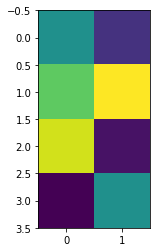

In [55]:
# print(output_cl1.shape)
new_img = np.reshape(output_cl1, [4, 2])
fig = plt.figure(figsize=(2,4))
plt.imshow(new_img, interpolation='none', aspect='auto')

In [ ]:
img_x = cv2.imread("../../original_images/SD/15970/0/labels/merged_patch.png")
print(img_x.shape)
reshaped_img_x = np.expand_dims(img_x, axis=0)

grey_img = np.dot(img_x[...,:3], [0.299, 0.587, 0.114])
print(grey_img.shape)

# grey_img = normalize(grey_img)

# see_output(reshaped_img_x, figsize=(2,4))

fig = plt.figure(figsize=(2,4))
# print(grey_img)
plt.imshow(grey_img, interpolation='none', aspect='auto')
# see_output(reshaped_img_x, figsize = (2,4))

In [18]:
def get_tensors(graph=tf.get_default_graph()):
    return [t for op in graph.get_operations() for t in op.values()]
get_tensors()

[<tf.Tensor 'x_orig:0' shape=(?, 300) dtype=float32>,
 <tf.Tensor 'x_pred:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'Reshape/shape:0' shape=(4,) dtype=int32>,
 <tf.Tensor 'Reshape:0' shape=(?, 10, 10, 3) dtype=float32>,
 <tf.Tensor 'Reshape_1/shape:0' shape=(4,) dtype=int32>,
 <tf.Tensor 'Reshape_1:0' shape=(?, 10, 10, 1) dtype=float32>,
 <tf.Tensor 'Const:0' shape=(2,) dtype=int32>,
 <tf.Tensor 'Const_1:0' shape=() dtype=int32>,
 <tf.Tensor 'y_true:0' shape=(?, 4, 2) dtype=float32>,
 <tf.Tensor 'y_true_cls:0' shape=(?, 4, 2) dtype=float32>,
 <tf.Tensor 'cv/random_uniform/shape:0' shape=(4,) dtype=int32>,
 <tf.Tensor 'cv/random_uniform/min:0' shape=() dtype=float32>,
 <tf.Tensor 'cv/random_uniform/max:0' shape=() dtype=float32>,
 <tf.Tensor 'cv/random_uniform/RandomUniform:0' shape=(4, 4, 1, 16) dtype=float32>,
 <tf.Tensor 'cv/random_uniform/sub:0' shape=() dtype=float32>,
 <tf.Tensor 'cv/random_uniform/mul:0' shape=(4, 4, 1, 16) dtype=float32>,
 <tf.Tensor 'cv/random_uniform:0' sh